<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


NameError: name 'stable_baselines3' is not defined

In [ ]:
pip install tensorboardX -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
pip install git+https://github.com/quantopian/pyfolio

In [ ]:
## install finrl library
!pip install wrds -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install swig -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git 


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [5]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2021-02-28'

In [4]:
TRAIN_START_DATE = '2012-10-10'
TRAIN_END_DATE = '2021-02-28'
TRADE_START_DATE = '2021-03-01'
TRADE_END_DATE = '2022-02-28'


In [6]:
import tushare as ts
ts.set_token('6314756019e50a6672690e5a78b2dbf7cfcd27c6f6a6b48a8cf76dae')
pro = ts.pro_api()

In [7]:
#选择上证50指数的成分股
df_index = pro.index_weight(index_code='000016.sh', start_date='20121010', end_date='20220228')
# df_index.to_csv('SSE_50_index_weight.csv',index=0)

In [8]:
#选择某个时间点的上证50指数成分股作为参考跟踪股票池
select_date = '20200228' #自定义的时间点为每个月的月末
df_select = df_index[df_index['trade_date']==select_date]
sort_SSEindex = df_select['con_code'].unique()
print(sort_SSEindex,len(sort_SSEindex))

['603993.SH' '603259.SH' '601989.SH' '601988.SH' '601939.SH' '601888.SH'
 '601857.SH' '601818.SH' '601766.SH' '601688.SH' '601668.SH' '601628.SH'
 '601601.SH' '601398.SH' '601390.SH' '601336.SH' '601328.SH' '601319.SH'
 '601318.SH' '601288.SH' '601236.SH' '601211.SH' '601186.SH' '601166.SH'
 '601138.SH' '601111.SH' '601088.SH' '601066.SH' '601012.SH' '600887.SH'
 '600837.SH' '600703.SH' '600690.SH' '600585.SH' '600547.SH' '600519.SH'
 '600340.SH' '600309.SH' '600276.SH' '600196.SH' '600104.SH' '600050.SH'
 '600048.SH' '600036.SH' '600031.SH' '600030.SH' '600028.SH' '600016.SH'
 '600009.SH' '600000.SH'] 50


In [9]:
#随机选择成分股中的k只股票
import random 
k = 20
selected_tics = random.sample(list(sort_SSEindex),k)
print(selected_tics)

['600887.SH', '603993.SH', '601398.SH', '601318.SH', '600036.SH', '601818.SH', '600340.SH', '603259.SH', '601012.SH', '600000.SH', '601989.SH', '600050.SH', '601066.SH', '601390.SH', '600703.SH', '601766.SH', '601236.SH', '601138.SH', '600196.SH', '600016.SH']


In [ ]:
#如果选择从config中配置可以用这段代码快速更改后缀
# new = []
# for c in config_tickers.SSE_50_TICKER:
#     c = c.replace('XSHG','SH')
#     new.append(c)
# print(new,len(new))

In [10]:
#Download随机选择的k只股票数据
df_ts =pd.DataFrame()
for c in selected_tics:
    temp=pro.daily(ts_code=c,start_date='20121010',end_date='20220228')
    df_ts=pd.concat([df_ts,temp])
print(df_ts)

        ts_code trade_date   open   high    low  close  pre_close  change  \
0     600887.SH   20220228  39.03  39.54  39.01  39.52      39.50    0.02   
1     600887.SH   20220225  39.66  40.12  39.30  39.50      39.52   -0.02   
2     600887.SH   20220224  40.13  40.13  38.94  39.52      40.24   -0.72   
3     600887.SH   20220223  41.00  41.20  40.05  40.24      40.49   -0.25   
4     600887.SH   20220222  40.73  40.78  39.90  40.49      41.01   -0.52   
...         ...        ...    ...    ...    ...    ...        ...     ...   
2277  600016.SH   20121016   5.78   5.84   5.76   5.83       5.78    0.05   
2278  600016.SH   20121015   5.80   5.81   5.74   5.78       5.78    0.00   
2279  600016.SH   20121012   5.74   5.82   5.74   5.78       5.73    0.05   
2280  600016.SH   20121011   5.70   5.74   5.65   5.73       5.71    0.02   
2281  600016.SH   20121010   5.74   5.77   5.69   5.71       5.74   -0.03   

      pct_chg        vol       amount  
0      0.0506  247484.40   971809.1

In [ ]:
# #检验50只股票的信息缺省的时间点和个数
# dimatch_num = 0
# dimatch_date =[]
# for c in df_ts1['trade_date'].unique():
#     temp = df_ts1[df_ts1['trade_date'] == c]
#     if len(temp) != 50:
#         dimatch_num +=1
#         dimatch_date.append(c)
# print(dimatch_num,dimatch_date)

In [ ]:
# #获取SSE的交易日历
# import exchange_calendars as tc
# def get_trading_days(exchange: str, start_date: str, end_date: str):
#     days = pro.trade_cal(exchange=exchange, start_date=start_date, end_date=end_date)
#     days = days[days['is_open'] == 1]
#     full_date_range = pd.DataFrame({'trade_date':days['cal_date']})
#     full_date_range['trade_date'] = full_date_range['trade_date'].astype(str)
#     return full_date_range

# full_date_range = get_trading_days(exchange='SSE',start_date='20121010', end_date='20230228')
# print(full_date_range)

In [ ]:
# date_unique = df['date'].unique()
# date_sum = len(date_unique)
# count = 0
# for date in date_unique:
#     temp_df = df[df['trade_date'] == date]
# #     if len(temp_df) = k:
# #         count +=1
# #     elif len(temp_df) < int(0.9*k):
# #         date_unique.remove(date)
# #     else:
#     difference_tic = temp_df['ts_code'].tolist().difference(selected_tics)
#     missing_tic.append(date,difference_tic)

In [ ]:
# #遍历扩充股票的完整交易日期
# def add_exchange_calendars(df,full_date_range,selected_tics):
#     merge_df = []
#     for tic in selected_tics:
#         temp_df = df[df['ts_code'] == tic]
#         temp_full_date_range = full_date_range
#         temp_df = temp_df.set_index('trade_date')
#         temp_full_date_range = temp_full_date_range.set_index('trade_date')
#         temp_df = pd.merge(temp_full_date_range,temp_df,how='left',left_index=True,right_index=True)
#         temp_df = temp_df.reset_index().sort_values('trade_date',ascending=True)
#         temp_df = temp_df.fillna({
#             'amount' : 0,
#             'vol': 0,
#             'pct_chg': 0,
#             'change':0,
#             'ts_code': tic
#         })
#         for i in range(len(temp_df)):
#             if pd.isna(temp_df.loc[i,'close']):
#                 j = i -1
#                 while pd.isna(temp_df.loc[j,'close']):
#                     j = j - 1
#                 if j > 0 :
#                     temp_df.loc[i,['close','open','high','low','pre_close']] = temp_df.loc[j,'close']
#         merge_df.append(temp_df)
#     merged_df = pd.concat(merge_df,ignore_index = True)
#     return merged_df

# merged_df =  add_exchange_calendars(df_ts,full_date_range,selected_tics)
# merged_df = merged_df.rename(columns={'trade_date':'date','ts_code':'tic','vol':'volume'})
# merged_df = merged_df[['tic','date','open','high','low','close','pre_close','change','pct_chg','volume','amount']]
# print(merged_df)

In [11]:
# 筛选exchange_calender中每个交易节点缺失情况
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) < int(0.9*k):
            date_unique.remove(date)
        elif len(temp_df) >= int(0.9*k) and len(temp_df) < k:
            missing_tic = set(selected_tics).difference(set(temp_df['ts_code'].tolist()))
            print(missing_tic)
            for m_tic in missing_tic:
                temp_dict = {'ts_code':m_tic,'trade_date':date,'open':np.nan, 'high':np.nan,'low':np.nan, 'close':np.nan, 'pre_close':np.nan, 'change':np.nan, 'pct_chg':np.nan, 'volume':np.nan, 'amount':np.nan}
                new_data = pd.DataFrame.from_dict(temp_dict,orient='index').T
                temp_df = temp_df.append(new_data)
#             print(len(temp_df))
            processe_df.append(temp_df)
        else :
            count += 1
            processe_df.append(temp_df)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique
        

In [47]:
# 筛选exchange_calender中每个交易节点缺失(激进)
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) == k:
            processe_df.append(temp_df)
        else :
            date_unique.remove(date)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique
        

In [48]:
processed_df,date_unique = processed_date(df_ts,selected_tics,k)
print(processed_df) 

         ts_code trade_date   open   high    low  close  pre_close  change  \
0      600016.SH   20190705   6.13   6.13   6.08   6.09       6.10   -0.01   
1      600887.SH   20190705  33.47  33.59  33.23  33.47      33.41    0.06   
2      603993.SH   20190705   4.02   4.03   3.99   4.01       4.02   -0.01   
3      601398.SH   20190705   5.66   5.68   5.65   5.67       5.68   -0.01   
4      601318.SH   20190705  90.00  91.14  89.83  90.85      89.90    0.95   
...          ...        ...    ...    ...    ...    ...        ...     ...   
12415  601138.SH   20220228  11.18  11.20  11.00  11.17      11.20   -0.03   
12416  600196.SH   20220228  41.99  42.60  41.68  42.40      42.10    0.30   
12417  600016.SH   20220228   3.91   3.92   3.89   3.91       3.91    0.00   
12418  601989.SH   20220228   4.07   4.13   4.05   4.11       4.08    0.03   
12419  600887.SH   20220228  39.03  39.54  39.01  39.52      39.50    0.02   

       pct_chg         vol       amount  
0      -0.1639   8977

In [ ]:
print(processed_df,len(date_unique))

In [49]:
def process_fillna(df,selected_tics,k):
    merge_df = []
    for tic in selected_tics:
        temp_df = df[df['ts_code']==tic]
        temp_df = temp_df.reset_index().sort_values('trade_date',ascending=True)
        temp_df = temp_df.fillna({
            'amount' : 0,
            'vol': 0,
            'pct_chg': 0,
            'change':0,
            'ts_code': tic
        })
        for i in range(len(temp_df)):
            if pd.isna(temp_df.loc[i,'close']):
                j = i +1
                while pd.isna(temp_df.loc[j,'close']):
                    j = j + 1
                if j < len(temp_df) :
                    temp_df.loc[i,['close','open','high','low','pre_close']] = temp_df.loc[j,'close']
        merge_df.append(temp_df)
    merged_df = pd.concat(merge_df,ignore_index = True)
    return merged_df

In [53]:
merged_df = process_fillna(processed_df,selected_tics,k)
merged_df = merged_df.drop('index',axis=1)
merged_df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600887.SH,20190705,33.47,33.59,33.23,33.47,33.41,0.06,0.1796,358528.46,1199123.538
1,600887.SH,20190708,33.35,33.38,32.47,32.98,33.47,-0.49,-1.4640,544269.60,1794375.454
2,600887.SH,20190709,32.98,33.50,32.85,33.27,32.98,0.29,0.8793,406063.39,1351117.124
3,600887.SH,20190710,33.69,33.73,32.90,33.16,33.27,-0.11,-0.3306,384073.99,1278001.552
4,600887.SH,20190711,33.48,34.20,33.29,33.88,33.16,0.72,2.1713,549605.28,1861941.170
...,...,...,...,...,...,...,...,...,...,...,...
12415,600016.SH,20220222,3.97,3.97,3.95,3.96,3.97,-0.01,-0.2519,532923.61,211009.752
12416,600016.SH,20220223,3.96,3.96,3.94,3.96,3.96,0.00,0.0000,522851.68,206474.823
12417,600016.SH,20220224,3.95,3.96,3.90,3.91,3.96,-0.05,-1.2626,917394.25,359719.096
12418,600016.SH,20220225,3.91,3.93,3.90,3.91,3.91,0.00,0.0000,608925.44,238356.949


In [55]:
# merged_df = merged_df.drop('volume',axis=1)
merged_df = merged_df.rename(columns={'trade_date':'date','ts_code':'tic','vol':'volume'})
merged_df = merged_df[['tic','date','open','high','low','close','pre_close','change','pct_chg','volume','amount']]
# merged_df = merged_df.drop('index',axis=1)
merged_df = merged_df.sort_values(['tic','date'],ascending=True).reset_index(drop=True)
print(merged_df)

             tic      date   open   high    low  close  pre_close  change  \
0      600000.SH  20190705  11.63  11.64  11.53  11.57      11.62   -0.05   
1      600000.SH  20190708  11.56  11.57  11.31  11.36      11.57   -0.21   
2      600000.SH  20190709  11.40  11.43  11.33  11.37      11.36    0.01   
3      600000.SH  20190710  11.43  11.43  11.31  11.35      11.37   -0.02   
4      600000.SH  20190711  11.43  11.46  11.34  11.40      11.35    0.05   
...          ...       ...    ...    ...    ...    ...        ...     ...   
12415  603993.SH  20220222   5.70   5.77   5.66   5.76       5.73    0.03   
12416  603993.SH  20220223   5.79   5.81   5.72   5.80       5.76    0.04   
12417  603993.SH  20220224   5.76   5.89   5.62   5.72       5.80   -0.08   
12418  603993.SH  20220225   5.71   5.85   5.69   5.74       5.72    0.02   
12419  603993.SH  20220228   5.77   6.05   5.77   6.01       5.74    0.27   

       pct_chg      volume       amount  
0      -0.4303   257532.41   2981

In [ ]:
#保存预处理后的数据
merged_df.to_csv('merged_df.csv',index=0)

In [ ]:
merged_df = pd.read_csv('merged_df.csv')
merged_df

In [16]:
merged_df

,tic,date,open,high,low,close,pre_close,change,pct_chg,volume,amount,volume
0,600000.SH,20180620,9.92,9.98,9.87,9.89,9.92,-0.03,-0.3000,189157.40,187504.468,NaN
1,600000.SH,20180621,9.88,9.98,9.75,9.83,9.89,-0.06,-0.6100,236369.61,234236.776,NaN
2,600000.SH,20180622,9.83,9.83,9.67,9.76,9.83,-0.07,-0.7100,250400.01,243586.307,NaN
3,600000.SH,20180625,9.77,9.82,9.55,9.56,9.76,-0.20,-2.0500,242443.80,234851.670,NaN
4,600000.SH,20180626,9.60,9.60,9.35,9.48,9.56,-0.08,-0.8400,244240.95,231698.549,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17935,603993.SH,20220222,5.70,5.77,5.66,5.76,5.73,0.03,0.5236,897876.28,512858.147,NaN
17936,603993.SH,20220223,5.79,5.81,5.72,5.80,5.76,0.04,0.6944,1185717.16,685169.825,NaN
17937,603993.SH,20220224,5.76,5.89,5.62,5.72,5.80,-0.08,-1.3793,1727187.53,996628.278,NaN
17938,603993.SH,20220225,5.71,5.85,5.69,5.74,5.72,0.02,0.3497,1485125.03,859014.268,NaN


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [56]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=False,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.add_technical_indicator(merged_df)
processed = fe.add_turbulence(processed)
processed = processed.fillna(method="ffill").fillna(method="bfill")

In [ ]:
processed

In [57]:
list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

In [58]:
import datetime
processed_full['date'] = pd.to_datetime(processed_full['date'],format='%Y%m%d')
processed_full

,tic,date,open,high,low,close,pre_close,change,pct_chg,volume,amount,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,600000.SH,2019-07-05,11.63,11.64,11.53,11.57,11.62,-0.05,-0.4303,257532.41,298158.887,0.000000,11.761985,11.168015,0.000000,-66.666667,100.000000,11.570000,11.570000,0.000000
1,600016.SH,2019-07-05,6.13,6.13,6.08,6.09,6.10,-0.01,-0.1639,897742.79,547646.264,0.000000,11.761985,11.168015,0.000000,-66.666667,100.000000,6.090000,6.090000,0.000000
2,600036.SH,2019-07-05,36.20,36.63,36.00,36.47,36.08,0.39,1.0809,364515.91,1325134.309,0.000000,11.761985,11.168015,0.000000,-66.666667,100.000000,36.470000,36.470000,0.000000
3,600050.SH,2019-07-05,6.22,6.22,6.17,6.20,6.21,-0.01,-0.1610,705261.80,436534.220,0.000000,11.761985,11.168015,0.000000,-66.666667,100.000000,6.200000,6.200000,0.000000
4,600196.SH,2019-07-05,26.68,26.94,26.58,26.81,26.51,0.30,1.1316,130610.00,350094.412,0.000000,11.761985,11.168015,0.000000,-66.666667,100.000000,26.810000,26.810000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12415,601766.SH,2022-02-28,5.83,5.83,5.76,5.79,5.81,-0.02,-0.3442,436976.83,252651.647,-0.060305,6.108218,5.763782,41.309528,-155.220808,34.136497,5.997000,6.062500,11.070089
12416,601818.SH,2022-02-28,3.34,3.35,3.32,3.34,3.34,0.00,0.0000,1080148.35,360152.181,-0.007513,3.508380,3.305620,45.030352,-166.602431,21.155192,3.411000,3.382333,11.070089
12417,601989.SH,2022-02-28,4.07,4.13,4.05,4.11,4.08,0.03,0.7353,881299.44,361405.999,-0.013572,4.157704,3.990296,48.243054,-5.198242,19.158363,4.104333,4.157000,11.070089
12418,603259.SH,2022-02-28,103.50,105.35,102.44,103.93,103.40,0.53,0.5126,184600.31,1908742.447,-2.570438,111.976948,83.659052,45.758254,1.464629,9.773994,103.137000,114.427333,11.070089


In [ ]:
len(processed_full['date'].unique())

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [59]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

7800
4600


In [ ]:
train.tail()

In [ ]:
trade.head()

In [ ]:
INDICATORS

In [60]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 20, State Space: 201


In [61]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)


## Environment for Training



In [62]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [63]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False


In [34]:
import torch
device = torch.device("mps")

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

### Agent 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

### Agent 3: PPO

In [64]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [65]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=30000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 1187       |
|    iterations      | 1          |
|    time_elapsed    | 1          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -155.62257 |
-----------------------------------
day: 389, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1090496.29
total_reward: 90496.29
total_cost: 11365.42
total_trades: 7378
Sharpe: 0.644
-----------------------------------------
| time/                   |             |
|    fps                  | 1149        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005768911 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.4       |
|    explained_variance   | 1.19e-07    |
|    learning_r

------------------------------------------
| time/                   |              |
|    fps                  | 1118         |
|    iterations           | 11           |
|    time_elapsed         | 20           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0032125646 |
|    clip_fraction        | 0.00137      |
|    clip_range           | 0.2          |
|    entropy_loss         | -28.4        |
|    explained_variance   | -4.77e-07    |
|    learning_rate        | 0.00025      |
|    loss                 | 5.29e+08     |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00413     |
|    reward               | -5512.1777   |
|    std                  | 1            |
|    value_loss           | 1.26e+09     |
------------------------------------------
day: 389, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 1266115.03
total_reward: 266115.03
total_cost: 11729.12
total_trades: 7

### Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000) if if_using_td3 else None

### Agent 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=40000) if if_using_sac else None

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [66]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

In [ ]:
insample_risk_indicator.turbulence.describe()

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [67]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='turbulence', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

In [68]:
trained_moedl = trained_ppo
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.shape

In [69]:
df_account_value.tail()

,date,account_value
225,2022-02-21,981133.12777
226,2022-02-22,979028.63252
227,2022-02-23,982912.30607
228,2022-02-24,981233.93711
229,2022-02-25,987729.08050


In [ ]:
df_actions.head()

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [70]:
print("==============Get Backtest Results===========")
#now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.013437
Cumulative returns    -0.012271
Annual volatility      0.057626
Sharpe ratio          -0.206777
Calmar ratio          -0.187189
Stability              0.120100
Max drawdown          -0.071782
Omega ratio            0.948670
Sortino ratio         -0.245686
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.881662
Daily value at risk   -0.007307
dtype: float64


In [71]:
#获取随机选择的tic在select_date的权重并修正
def get_selected_index_weight(df_index,select_date,selected_tics):
    df = df_index[df_index['trade_date'] == select_date]
    select_df = df[df['con_code'].isin(selected_tics)]
    select_df = select_df.drop('index_code',axis=1).rename(columns={'con_code':'tic','trade_date':'date'})
    select_df = select_df.reset_index()
    weight_sum = select_df['weight'].sum()
#     print(select_df)
    for i in range(len(select_df)):
        select_df.loc[i,'weight'] = (select_df.loc[i,'weight'] / weight_sum)*100
    return select_df.loc[:,['tic','date','weight']]

baseline_weight =get_selected_index_weight(df_index,select_date,selected_tics)
baseline_weight = baseline_weight.sort_values(['tic'],ascending=True).reset_index(drop=True)
print(baseline_weight)

          tic      date     weight
0   600000.SH  20200228   5.377721
1   600016.SH  20200228   5.992318
2   600036.SH  20200228  14.890001
3   600050.SH  20200228   2.153416
4   600196.SH  20200228   1.140729
5   600340.SH  20200228   1.201257
6   600703.SH  20200228   2.546851
7   600887.SH  20200228   7.440345
8   601012.SH  20200228   3.422186
9   601066.SH  20200228   0.607613
10  601138.SH  20200228   1.287394
11  601236.SH  20200228   0.363171
12  601318.SH  20200228  35.537190
13  601390.SH  20200228   1.846118
14  601398.SH  20200228   4.825981
15  601766.SH  20200228   2.628332
16  601818.SH  20200228   2.539867
17  601989.SH  20200228   1.704109
18  603259.SH  20200228   3.282505
19  603993.SH  20200228   1.212897


In [72]:
#计算所选股票的buy & hold策略
def calculate_selected_baseline(df,full_date_range,selected_tics):
    df = df.sort_values(['tic','date'],ascending=True).reset_index(drop=True)
    baseline = pd.DataFrame({'date':full_date_range['date']})
    for i in range(len(full_date_range)):
        temp_date = full_date_range.loc[i,'date']
        temp_df = df[df['date'] == temp_date].sort_values('tic',ascending=True)
        close = list(temp_df['close'])
        weight = list(baseline_weight['weight'])
        baseline.loc[i,'account_value'] = sum(np.array(close) * np.array(weight)) #注意权重和收盘价对应的股票顺序
    baseline['date'] = pd.to_datetime(baseline['date'])
#     baseline.set_index("date", inplace=True, drop=True)
#     baseline.index = baseline.index.tz_localize("UTC")
    return baseline
# full_date_range = get_trading_days(exchange='SSE',start_date='20210301', end_date='20230227')
# full_date_range = full_date_range.sort_values('trade_date',ascending=True).reset_index(drop=True)
subset_df = merged_df.loc[(merged_df['date'] >='20210301') & (merged_df['date']<='20220227')]
full_date_range1 = pd.DataFrame({'date':subset_df['date'].unique()}).reset_index(drop=True)
baseline_sse = calculate_selected_baseline(merged_df,full_date_range1,selected_tics)
baseline_sse

,date,account_value
0,2021-03-01,5318.559679
1,2021-03-02,5221.030381
2,2021-03-03,5408.790455
3,2021-03-04,5304.308928
4,2021-03-05,5219.330229
...,...,...
225,2022-02-21,3867.089303
226,2022-02-22,3810.995530
227,2022-02-23,3820.679665
228,2022-02-24,3747.180258


In [ ]:
baseline_sse.info()

In [ ]:
# baseline_sse = pro.index_daily(ts_code='000016.sh',start_date = '20200301',end_date='20230227')
# baseline_sse = baseline_sse.rename(columns={'trade_date':'date'})
# baseline_sse = baseline_sse.sort_values('date',ascending=True)
# print(baseline_sse)

In [73]:
#baseline stats
print("==============Get Baseline Stats===========")
# baseline_df = get_baseline(
#         ticker="^DJI", 
#         start = df_account_value.loc[0,'date'],
#         end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_sse, value_col_name = 'account_value')


==============Get Baseline Stats===========
Annual return         -0.315391
Cumulative returns    -0.292366
Annual volatility      0.215560
Sharpe ratio          -1.657025
Calmar ratio          -0.987342
Stability              0.872821
Max drawdown          -0.319435
Omega ratio            0.752735
Sortino ratio         -2.271085
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.120311
Daily value at risk   -0.028575
dtype: float64


In [ ]:
df_account_value

<a id='6.2'></a>
## 7.2 BackTestPlot

In [74]:
import pyfolio
from copy import deepcopy
def backtest_plot_com(
    account_value,
    baseline,
    baseline_start=TRADE_START_DATE,
    baseline_end=TRADE_END_DATE,
    value_col_name="account_value",
):
    df = deepcopy(account_value)
    df["date"] = pd.to_datetime(df["date"])
    test_returns = get_daily_return(df, value_col_name=value_col_name)
#     pro = ts.pro_api()
#     baseline_df = pro.index_daily(ts_code='000016.sh',start_date = '20200301',end_date='20230227')
#     baseline_df = baseline_df.rename(columns={'trade_date':'date'})
#     baseline_df = baseline_df.sort_values('date',ascending=True)
    baseline_returns = get_daily_return(baseline, value_col_name=value_col_name)
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )

==============Compare to SSE50===========


Start date,2021-03-01
End date,2022-02-25
Total months,10
,Backtest
Annual return,-1.344%
Cumulative returns,-1.227%
Annual volatility,5.763%
Sharpe ratio,-0.21
Calmar ratio,-0.19
Stability,0.12
Max drawdown,-7.178%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.18,2021-06-04,2022-02-11,NaT,NaN
1,1.41,2021-04-29,2021-05-07,2021-05-17,13
2,0.71,2021-04-08,2021-04-12,2021-04-23,12
3,0.54,2021-05-27,2021-05-28,2021-06-01,4
4,0.36,2021-03-12,2021-03-24,2021-03-26,11


Stress Events,mean,min,max
New Normal,-0.00%,-3.59%,1.08%


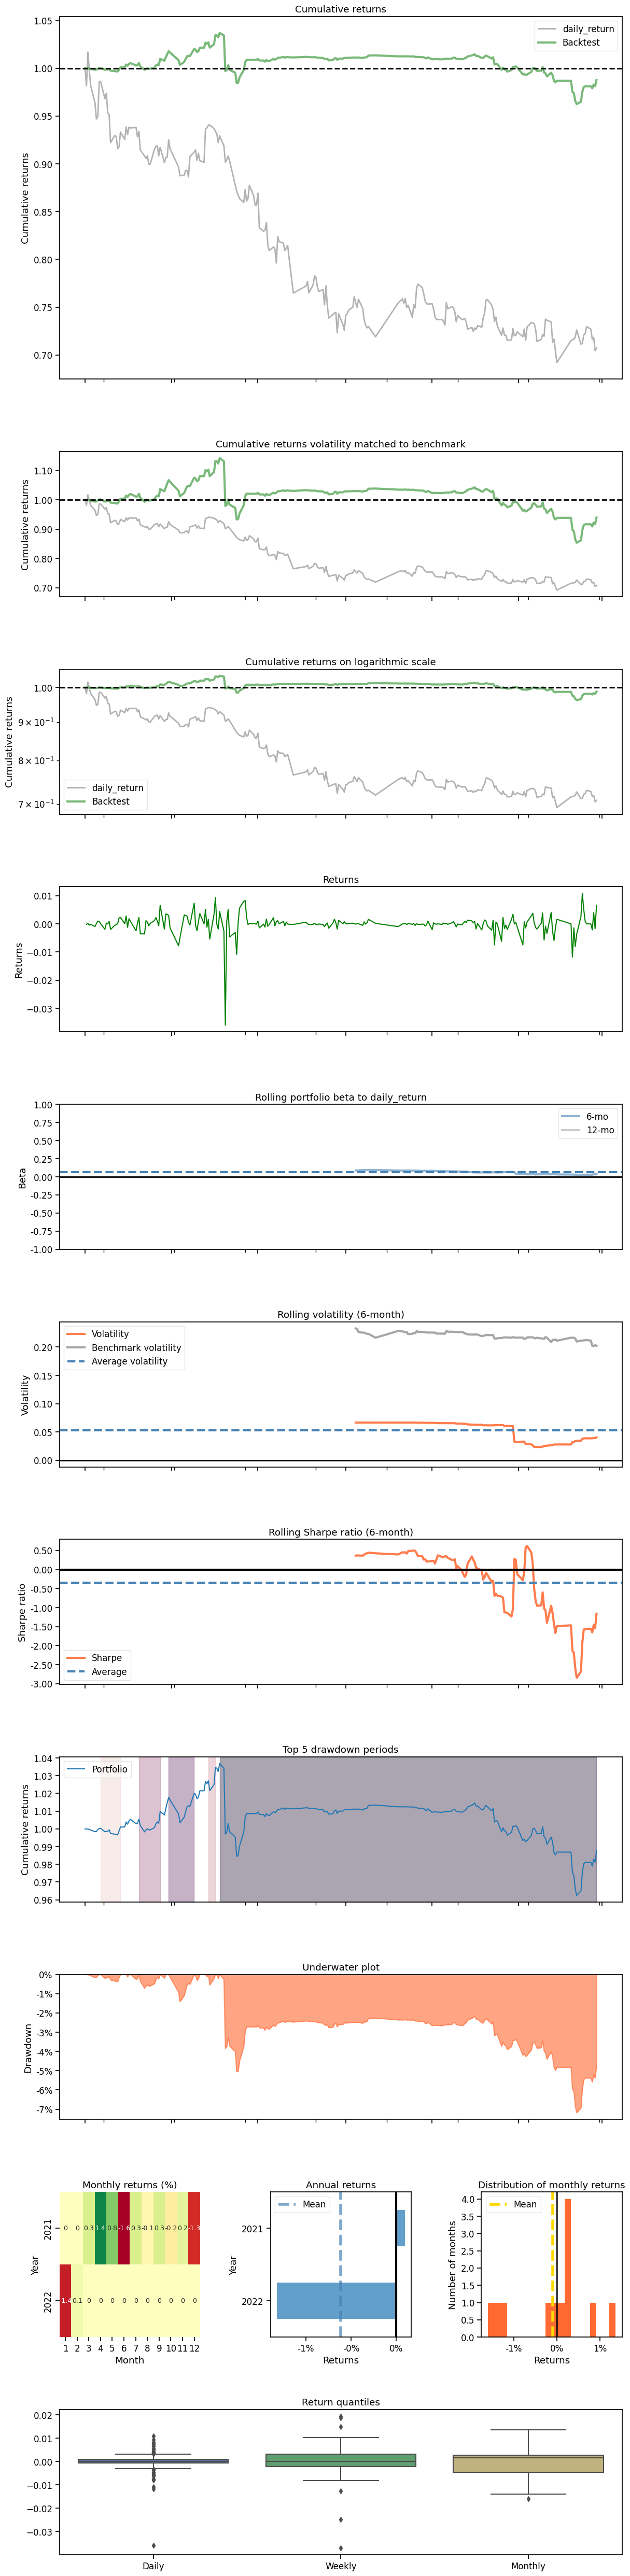

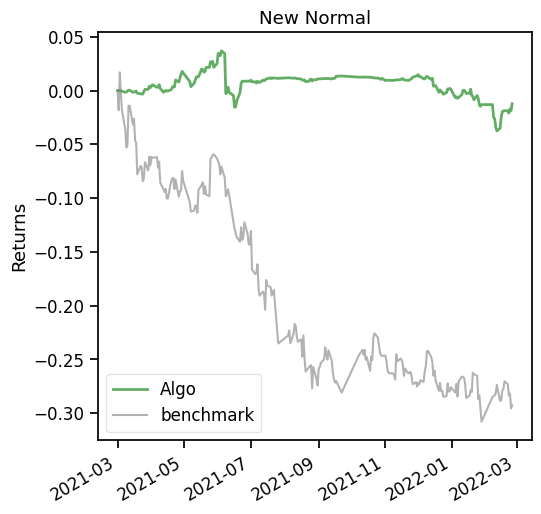

In [75]:
print("==============Compare to SSE50===========")
# from finrl.plot import backtest_plot_com
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot_com(account_value = df_account_value, 
                  baseline = baseline_sse,
                  baseline_start = df_account_value.loc[len(df_account_value)-1,'date'],
                  baseline_end = df_account_value.loc[0,'date']
                     )

In [ ]:
print(df_account_value.loc[len(df_account_value)-1,'date'],df_account_value.loc[0,'date'])